<a href="https://colab.research.google.com/github/rajensalim/nsfw_filter/blob/main/nudity_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle #install only if needed

In [ ]:
! mkdir ~/.kaggle

In [ ]:
#import drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#copy the kaggle.json file from drive
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json


In [ ]:
! cp kaggle.json ~/.kaggle/ #if you upload the kaggle.json file directly, skip the import drive stuffs

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

#Initialize

In [ ]:
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random
import shutil
import pathlib
from PIL import Image
from shutil import copyfile
from google.colab import files
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
Image.MAX_IMAGE_PIXELS = None
warnings.simplefilter('error', Image.DecompressionBombWarning)

In [ ]:
# download dataset
! kaggle datasets download drakedtrex/my-nsfw-dataset

 98% 641M/652M [00:07<00:00, 86.1MB/s]
100% 652M/652M [00:07<00:00, 94.6MB/s]


#MobileNetV2

In [ ]:
def create_pre_trained_model(local_weights):
  pre_trained_model = MobileNetV2(input_shape = (224, 224, 3), 
                                   include_top = False, 
                                   weights = local_weights)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [ ]:
# Create an instance of the inception model from the local pre-trained weights
local_weights= 'imagenet'

#Model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# choose base model
last_layer = pre_trained_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 1280)


In [ ]:
# flatten last layer into 1 dimensi
x = layers.Flatten()(last_output)
# add connected layer
x = layers.Dense(100, activation='relu')(x)
# add a dropout layer
x = layers.Dropout(0.2)(x)                  
# add final layer, sigmoid activation is used for binary classification (NSFW or SFW)
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 
# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

# Preprocessing Data

In [ ]:
# Extract the archive
def extract_file(source_path):
  zip_ref = zipfile.ZipFile("./my-nsfw-dataset.zip", 'r')
  zip_ref.extractall(source_path)
  zip_ref.close()

  source_path_NSFW = os.path.join(source_path, 'train/train/NSFW')
  source_path_SFW = os.path.join(source_path, 'train/train/SFW')

  print(f"There are {len(os.listdir(source_path_NSFW))} images of NSFW.")
  print(f"There are {len(os.listdir(source_path_SFW))} images of SFW.")

In [ ]:
extract_file('tmp/file_nudity')

There are 738 images of NSFW.
There are 738 images of SFW.


In [ ]:
# Create directory for splitted file
if os.path.isdir('tmp/split_file') == False:
  base_dir = 'tmp/split_file'
  os.mkdir(base_dir)
else:
  print('Directory already exists!')

In [ ]:
# Create path for train and validation
def create_train_val_dirs(base_path):
  train_dir = os.path.join(base_dir, 'train')
  os.mkdir(train_dir)
  val_dir = os.path.join(base_dir, 'validation')
  os.mkdir(val_dir)

  # Directory with training NSFW pictures
  train_nsfw_dir = os.path.join(train_dir, 'NSFW')
  os.mkdir(train_nsfw_dir)
  # Directory with training SFW pictures
  train_sfw_dir = os.path.join(train_dir, 'SFW')
  os.mkdir(train_sfw_dir)

  # Directory with validation NSFW pictures
  validation_nsfw_dir = os.path.join(val_dir, 'NSFW')
  os.mkdir(validation_nsfw_dir)
  # Directory with validation SFW pictures
  validation_sfw_dir = os.path.join(val_dir, 'SFW')
  os.mkdir(validation_sfw_dir)
  
  pass

try:
  create_train_val_dirs(base_path=base_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):

  files = []
  for filename in os.listdir(SOURCE):
    files.append(filename)
  
  #split the files appended to files(list) into training set based on split size
  training_length = int(len(files)*SPLIT_SIZE)
  #define validation length by substracting the length of files(list) with training_length
  validation_length = int(len(files)-training_length)
  #shuffling the set by length of files(list)
  shuffled_set = random.sample(files, len(files))
  #splitting the files into training_set and validation_set
  training_set = shuffled_set[0:training_length]
  validation_set = shuffled_set[-validation_length:]

  for filename in training_set:
    copyfile(SOURCE + filename, TRAINING + filename)
  
  for filename in validation_set:
    copyfile(SOURCE + filename, VALIDATION + filename)
  

In [ ]:
NSFW_SOURCE_DIR = "tmp/file_nudity/train/train/NSFW/"
SFW_SOURCE_DIR = "tmp/file_nudity/train/train/SFW/"

TRAINING_DIR = "tmp/split_file/train/"
VALIDATION_DIR = "tmp/split_file/validation/"

TRAINING_NSFW_DIR = os.path.join(TRAINING_DIR, "NSFW/")
VALIDATION_NSFW_DIR = os.path.join(VALIDATION_DIR, "NSFW/")

TRAINING_SFW_DIR = os.path.join(TRAINING_DIR, "SFW/")
VALIDATION_SFW_DIR = os.path.join(VALIDATION_DIR, "SFW/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_NSFW_DIR)) > 0:
  for file in os.scandir(TRAINING_NSFW_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_SFW_DIR)) > 0:
  for file in os.scandir(TRAINING_SFW_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_NSFW_DIR)) > 0:
  for file in os.scandir(VALIDATION_NSFW_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_SFW_DIR)) > 0:
  for file in os.scandir(VALIDATION_SFW_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .75

# Run the function
split_data(NSFW_SOURCE_DIR, TRAINING_NSFW_DIR, VALIDATION_NSFW_DIR, split_size)
split_data(SFW_SOURCE_DIR, TRAINING_SFW_DIR, VALIDATION_SFW_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_NSFW_DIR))} images of NSFW for training")
print(f"There are {len(os.listdir(TRAINING_SFW_DIR))} images of SFW for training")
print(f"There are {len(os.listdir(VALIDATION_NSFW_DIR))} images of NSFW for validation")
print(f"There are {len(os.listdir(VALIDATION_NSFW_DIR))} images of SFW for validation")



There are 553 images of NSFW for training
There are 553 images of SFW for training
There are 185 images of NSFW for validation
There are 185 images of SFW for validation


In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 14 using train_datagen generator
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = 14,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))     

# Flow validation images in batches of 10 using test_datagen generator
validation_generator =  validation_datagen.flow_from_directory( VALIDATION_DIR,
                                                          batch_size  = 10,
                                                          class_mode  = 'binary', 
                                                          target_size = (224, 224))

Found 1106 images belonging to 2 classes.
Found 370 images belonging to 2 classes.


# Train the Model

In [ ]:
# Set the training parameters
lr=0.0001
model.compile(optimizer = RMSprop(learning_rate=lr), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 25,
            validation_steps = 10)

model.save('model.h5')

Epoch 1/25
50/50 [==============================] - 36s 658ms/step - loss: 0.8597 - accuracy: 0.7800 - val_loss: 0.5009 - val_accuracy: 0.8300
Epoch 2/25
50/50 [==============================] - 32s 642ms/step - loss: 0.3310 - accuracy: 0.8843 - val_loss: 0.4461 - val_accuracy: 0.8500
Epoch 3/25
50/50 [==============================] - 32s 647ms/step - loss: 0.2833 - accuracy: 0.9086 - val_loss: 0.6053 - val_accuracy: 0.8400
Epoch 4/25
50/50 [==============================] - 33s 657ms/step - loss: 0.3089 - accuracy: 0.9043 - val_loss: 0.1637 - val_accuracy: 0.9500
Epoch 5/25
50/50 [==============================] - 31s 623ms/step - loss: 0.2894 - accuracy: 0.9043 - val_loss: 0.3598 - val_accuracy: 0.8900
Epoch 6/25
50/50 [==============================] - 33s 670ms/step - loss: 0.2894 - accuracy: 0.9114 - val_loss: 0.5789 - val_accuracy: 0.8700
Epoch 7/25
50/50 [==============================] - 32s 643ms/step - loss: 0.2862 - accuracy: 0.9114 - val_loss: 0.5078 - val_accuracy: 0.8600

Visualize the training and validation accuracy

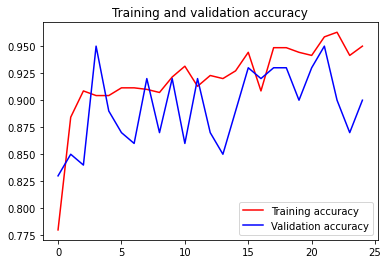

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

Test the model

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path=fn
  img=image.load_img(path, target_size=(224, 224))
  
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes)
  
  if classes<0.5:
    print(fn + " is inappropriate")
  else:
    print(fn + " is safe")

Saving Asli NSFW (1).png to Asli NSFW (1) (1).png
Saving Asli NSFW (2).png to Asli NSFW (2) (1).png
Saving Asli NSFW (3).png to Asli NSFW (3) (1).png
Saving Asli NSFW (4).png to Asli NSFW (4) (1).png
Saving Asli NSFW.png to Asli NSFW (5).png
Saving Asli SFW (1).jpg to Asli SFW (1) (1).jpg
Saving Asli SFW (2).jpg to Asli SFW (2) (1).jpg
Saving Asli SFW (3).jpg to Asli SFW (3) (1).jpg
Saving Asli SFW (4).jpg to Asli SFW (4) (1).jpg
Saving Asli SFW.jpg to Asli SFW (5).jpg
[[8.843282e-13]]
Asli NSFW (1).png is inappropriate
[[1.3309653e-14]]
Asli NSFW (2).png is inappropriate
[[3.3505755e-17]]
Asli NSFW (3).png is inappropriate
[[8.670939e-11]]
Asli NSFW (4).png is inappropriate
[[0.00010202]]
Asli NSFW.png is inappropriate
[[1.]]
Asli SFW (1).jpg is safe
[[0.9999999]]
Asli SFW (2).jpg is safe
[[0.8510017]]
Asli SFW (3).jpg is safe
[[0.9796402]]
Asli SFW (4).jpg is safe
[[0.00454445]]
Asli SFW.jpg is inappropriate


#Test Convert TFLite

Generate a SavedModel

In [ ]:
export_dir = 'saved_model/1'
tf.keras.models.save_model(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


Convert the SavedModel to TFLite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

33948508

Download the TFLite Model File

In [ ]:
try:
    from google.colab import files
    files.download(tflite_model_file)
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%cp -av saved_model/1 /content/drive/MyDrive

'saved_model/1/variables/variables.index' -> '/content/drive/MyDrive/1/variables/variables.index'
'saved_model/1/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/1/variables/variables.data-00000-of-00001'
'saved_model/1/saved_model.pb' -> '/content/drive/MyDrive/1/saved_model.pb'
'saved_model/1/keras_metadata.pb' -> '/content/drive/MyDrive/1/keras_metadata.pb'


In [ ]:
#Copy the .tflite model to drive
!cp model.tflite /content/drive/MyDrive

In [ ]:
#Copy the h.5 model to drive
!cp /content/model.h5 /content/drive/MyDrive